In [1]:
import numpy as np
import gym
import random
from time import sleep
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Q-Learning для игры Taxi-v3

В данной игре необходимо довезти пассажира до указанной точки с помощью такси. Так как пространство игры очень маленькое, то данную задачу можно решить с помощью Q-Learning

## 1 Создание игровой среды 
### 1.1 Правила игры

Что известно об игре:

- размер поля 5x5
- такси появляется в случайном месте
- пассажир появляется случайно в одной из четырех локаций: (R, B, G, Y) и хочет отправиться в одну из этих случайных локаций

Система вознаграждений:
- для каждого шага: -1
- при успешной доставке пассажира в назначенное место: +20
- при неверной высадке пассажира: -10

In [2]:
env = gym.make("Taxi-v3")
_ = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Для построение Q-Table нам необходимо знать количество состояний в игре и количество действий

In [3]:
state_space = env.observation_space.n
print("Количество возможных состояний:", state_space)
action_space = env.action_space.n
print("Количество возможных действий:", action_space,)

Количество возможных состояний: 500
Количество возможных действий: 6


В нашем случае Q-Table будет иметь размер 500 x 6

## 1.1 Создание вспомогательных классов

In [4]:
class TaxiGame:
    """ Класс игровой среды
    
    С помощью класса можно делать шаг в игре и получать
    обратную связь из игровой среды
    """
    
    def __init__(self):
        self._env = gym.make("Taxi-v3")
        self._state = self._env.reset()
              
    @property
    def state_space_size(self):
        """Возвращает количество состояний в игре"""
        return self._env.observation_space.n
    
    @property
    def action_space_size(self):
        """Возвращает количество действий в игре"""
        return self._env.action_space.n
    
    @property
    def current_state(self):
        """Возвращает номер текущего состояния в игре"""
        return self._state
    
    def action_space_sample(self):
        """Возвращает номер случайного действия в игре"""
        return self._env.action_space.sample()
    
    def reset(self):
        """Сброс игры"""
        self._state = self._env.reset()
        
    def render(self):
        """Отрисовка состояния игры"""
        self._env.render()
        
    def play_step(self, action: int) -> tuple:
        """Сделать игровой шаг
        
        Параметры
        ---------
        action : int
          Номер действия
          
        Результат
        ---------
        state, reward, done : (int, int, bool)
          state - состояние после выполнения шага
          reward - награда за выполнение шага
          done - если True, игра закончена
        """
        
        
        state, reward, done, info = self._env.step(action)
        self._state = state
        
        return state, reward, done

In [5]:
class QModel:
    """ Класс модели
    Инициализирует Q-Table
    
    Параметры
    ---------
    state_space_size : int
      Количество состояний в игре
    action_space_size : int
      Количество действий в игре
    """
    def __init__(self, state_space_size: int, action_space_size: int):
        
        self._state_space_size = state_space_size
        self._action_space_size = action_space_size
        
        self.q_table = np.zeros((self._state_space_size, self._action_space_size))

In [6]:
class QTrainer:
    """Тренер для Q-модели
    
    Параметры
    ---------
    model : QModel
      Экземпляр класса модели
    lr : float
      Скорость обучения. По умолчанию 0.01.
    gamma : float
      Коэффициент дисконтирования. По умолчанию 0.99
    """
    def __init__(self, model:QModel, lr: int=0.01, gamma: float=0.99):
        
        self._model = model
        self._lr = lr
        self._gamma = gamma
        
    def train_step(self, state: int, action: int, reward: int, new_state: int) -> None:
        """ Шаг обновления Q-table
        
        Параметры
        ---------
        state : int
          Состояние до выполнения шага
        action : int
          Предпринятое действие
        reward : int
          Награда за предпринятое действие
        new_state : int
          Состояние после выполнения шага
        """
        
        # Формула расчета Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        self._model.q_table[state, action] += self._lr * (reward + self._gamma * 
                                                          np.max(self._model.q_table[new_state]) 
                                                          - self._model.q_table[state, action])

In [7]:
class Agent:
    """
    Класс агента
    
    Параметры
    ---------
    lr : float
      Скорость обучения. По умолчанию 0.01.
    gamma : float
     Коэффициент дисконтирования. По умолчанию 0.99
    epsilon : float
      Параметр для политики выбора действий e-greedy. По умолчанию 1.0
      Здесь задается стартовое значение. С каждым эпизодом 
      значение уменьшается по следующей формуле:
      
      min_epsilon + (max_epsilon - min_epsilon) * e^(-decay_rate * episode_number)
      
      где episode_number - номер эпизода игры.
      
    max_epsilon : float
      Максимальное значение, которое может принимать epsilon. По умолчанию 1.0
    min_epsilon : float
      Минимальное значение epsilon. По умолчанию 0.001.
    decay_rate : float
      Коэффициент понижения значения epsilon. По умолчанию 0.01
    """
    
    def __init__(self, lr=0.01, gamma=0.99, epsilon=1.0, max_epsilon=1.0, min_epsilon=0.001,
                decay_rate=0.01):
        
        self._lr = lr
        self._gamma = gamma
        self._epsilon = epsilon
        self._max_epsilon = max_epsilon
        self._min_epsilon = min_epsilon
        self._decay_rate = decay_rate
        
        self.init()
        
    def init(self):
        
        self.game = TaxiGame()
        self.game.reset()
        
        self._model = QModel(state_space_size=self.game.state_space_size, 
                             action_space_size=self.game.action_space_size)
        self._trainer = QTrainer(model=self._model, lr=self._lr, gamma=self._gamma)
        
        self._n_episodes = 0
        
    def get_state(self):
        return self.game.current_state
        
    @property
    def n_episodes(self):
        return self._n_episodes
    
    @n_episodes.setter
    def n_episodes(self, n):
        self._n_episodes = n
        
    def get_action(self, state):
        """ Выбор действия с помощью политики epsilon-greedy.
        С вероятностью 1 - epsilon выбираем эксплуатацию опыта (наилучшее действие),
        с вероятностью epsilon выбираем режим исследования (случайный выбор действия).
        С увеличением кол-ва игр размер epsilon уменьшается.
        
        Параметры
        ---------
        state : int
          Номер текущего состояния
        """
        
        assert state is not None
        
        current_epsilon = self._min_epsilon + (self._max_epsilon - self._min_epsilon)*np.exp(-self._decay_rate*self._n_episodes)
        
        # Условие эксплуатации
        if(random.uniform(0,1) > current_epsilon):
            action = np.argmax(self._model.q_table[state])
        # иначе --> исследование
        else:
            action = self.game.action_space_sample()
            
        return action
    
    def train_q_table(self, state, action, reward, new_state):
        """ Обучаем Q-table на одном временном шаге
        
        Параметры
        ---------
        state : int
          Состояние до выполнения шага
        action : int
          Предпринятое действие
        reward : int
          Награда за предпринятое действие
        new_state : int
          Состояние после выполнения шага
        """
        self._trainer.train_step(state=state, action=action, reward=reward, new_state=new_state)

### 1.3 Анализ скорости уменьшения epsilon в зависимости от гиперпараметра decay_rate

В классе Agent есть параметр decay_rate, который влияет на скорость снижения коэффициента epsilon в политике выбора действия eps-greedy.

Проверим скорость уменьшения epsilon в зависимости от разных значений decay_rate. epsilon рассчитывается по следующей формуле:

$$ \epsilon = max\_epsilon + (max\_epsilon - min\_epsilon) * e^{(-decay\_rate * episode\_number)}$$

Чем больше epsilon, тем больше вероятность исследования окружающей среды со стороны агента.

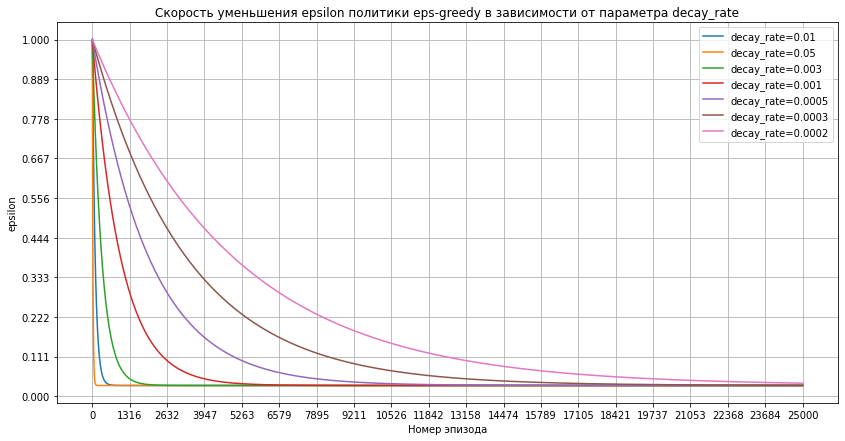

In [8]:
min_epsilon = 0.03
max_epsilon = 1.0
decay_rate = 0.03
num_episodes = 25000
episode_number = np.arange(0, num_episodes)

plt.figure(figsize=(14, 7))
for decay_rate in (0.01, 0.05, 0.003, 0.001, 0.0005, 0.0003, 0.0002):
    epsilons = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode_number)
    plt.plot(episode_number, epsilons, label=f"decay_rate={decay_rate}")

plt.title("Скорость уменьшения epsilon политики eps-greedy в зависимости от параметра decay_rate")
plt.xlabel("Номер эпизода")
plt.ylabel("epsilon")
plt.grid()
plt.xticks(np.linspace(0, num_episodes, 20))
plt.yticks(np.linspace(0, 1, 10))
plt.legend()
plt.show()

Из графика видно, что при уменьшении размера decay_rate, скорость уменьшения epsilon ниже. Мы будем обучать агента на 25000 эпизодах, в нашем случае можно пробовать брать decay_rate до 0.003 или ниже. 

## 2 Обучение агента

### 2.1 Создание вспомогательных функций

In [9]:
def train_loop(agent: Agent, total_episodes=25000, max_steps=250) -> tuple:
    """ Обучение агента
    
    Параметры
    ---------
    agent : Agent
      Экземпляр класса Agent
    total_episodes : int
      Количество эпизодов для обучения
    max_steps : int
      Максимальное число шагов в игре
    """
    
    # Инциализируем агента
    agent.init()
    
    # Делаем шаги по эпизодам
    for episode_idx in tqdm(range(total_episodes)):
        
        # Для каждого эпизода сбрасываем игру
        agent.game.reset()
        # Устанавливаем номер эпизода у агента, требуется для расчета epsilon
        agent.n_episodes = episode_idx
        
        # Делаем шаги в эпизоде
        for step_idx in range(max_steps):
            
            # Получаем текущее состояние
            state = agent.get_state()
            
            # С помощью политики получаем действие для текущего состояния
            action = agent.get_action(state)
            
            # Выполняем действие в среде и получаем от нее обратную связь
            new_state, reward, done = agent.game.play_step(action)
            
            # Тренируем Q-table
            agent.train_q_table(state=state, action=action, reward=reward, new_state=new_state)

            # Если эпизод закончен, то прерываем шаги по нему и переходим к следующему
            if done:
                break

In [10]:
def play_game(agent, total_episodes=1, max_steps=250, render=True) -> tuple:
    """ Играем агентов в игру
    
    Параметры
    ---------
    agent : Agent
      Обученный экземпляр класса Agent
    total_episodes : int
      Количество эпизодов для обучения
    max_steps : int
      Максимальное число шагов в игре
    render : bool
      Если True, то будет отрисован каждый шаг в игре
    
    Результат
    ---------
    rewards, steps : (list, list)
      rewards - список наград для каждого эпизода
      steps - список количества шагов для каждого эпизода
    """
    
    rewards = []
    steps = []
    
    for episode_idx in range(total_episodes):
        
        # Для каждого эпизода сбрасываем игру
        agent.game.reset()
        
        # Сумма нагрды в эпизоде
        total_rewards = 0
        # Сумма шагов в эпизоде
        total_steps = 0
        
        if render:
            print(f"Эпизод {episode_idx}")

        # Делаем шаги в эпизоде
        for step_idx in range(max_steps):
            
            if render:
                agent.game.render()
            
            # Получаем текущее состояние
            state = agent.get_state()
            
            # С помощью политики получаем действие для текущего состояния
            action = agent.get_action(state)
            
            # Выполняем действие в среде и получаем от нее обратную связь
            new_state, reward, done = agent.game.play_step(action)
            
            total_rewards += reward
            total_steps += 1

            if done:
                break
            
        rewards.append(total_rewards)
        steps.append(total_steps)
        
    return np.array(rewards), np.array(steps)

### 2.2 Обучение агента

In [11]:
config = {
    'agent': {
        'lr': 0.01, 
        'gamma': 0.99, 
        'epsilon': 1.0, 
        'max_epsilon': 1.0, 
        'min_epsilon': 0.001,
        'decay_rate': 0.003,
    },
    'train_loop': {
        'total_episodes': 25000,
        'max_steps': 250
    } 
}

In [12]:
agent = Agent(**config['agent'])

In [13]:
train_loop(agent, **config['train_loop'])

  0%|          | 0/25000 [00:00<?, ?it/s]

### 2.3 Проверка результатов обучения агента
#### 2.3.1 Визуализация одного эпизода игры

In [14]:
rewards, steps = play_game(agent, total_episodes=1, max_steps=250, render=True)

Эпизод 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y

In [15]:
print("Награда в эпизоде:", rewards[0])
print("Число шагов в эпизоде:", steps[0])

Награда в эпизоде: 9
Число шагов в эпизоде: 12


#### 2.3.2 Сбор статистики эффективности агента в игре

Соберем статистику игры агента на 5000 эпизодах

In [16]:
rewards, steps = play_game(agent, total_episodes=5000, max_steps=250, render=False)

In [17]:
print("Медианная награда в эпизоде:", np.median(rewards))
print("Средняя награда в эпизоде:", np.mean(rewards))
print("Медианное число шагов в эпизоде:", np.median(steps))
print("Среднее число шагов в эпизоде:", np.mean(steps))
print("Количество эпизодов с отрицательной наградой:", len(np.where(rewards < 0)[0]))

Медианная награда в эпизоде: 8.0
Средняя награда в эпизоде: 6.4694
Медианное число шагов в эпизоде: 13.0
Среднее число шагов в эпизоде: 14.3638
Количество эпизодов с отрицательной наградой: 47


Как видно из результатов, агент по медианному значению справляется с работой за 13 шагов. И получает примерно 8 очков награды из возможных 20. При этом количество эпизодов с отрицательной наградой составляем примерно 2% от их общего количества. В этом случае агент либо слишком долго довозит клиента до требуемого места, либо высаживает его в неверном месте. Это достаточно хороший результат.

# Итоги

В данной работе обучили агента играть игру Taxi-v3 с помощью техники Q-Learning. Создали необходимые классы для обучения агента, обучили его и визуализировали результаты работы обученного агента.